In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import RobustScaler, StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

In [2]:
heart_disease = pd.read_csv('heart_disease.csv')

# Table of contents
1. [Introduction](#introduction)
2. [Data exploration](#data-exploration)
3. [Data preparation](#data-preparation)
4. [Pipeline construction](#pipeline-construction)
5. [Initial fit results](#initial-fit-results)
6. [Improving the model](#improving-the-model)
7. [RFECV Pipeline construction](#rfecv-pipeline-construction)
8. [RFECV Pipeline results](#rfecv-pipeline-results)
9. [Hyperparameter Optimisation](#hyperparameter-optimisation)
10. [Final results](#final-results)
11. [Conclusion and next steps](#conclusion-and-next-steps)


## Introduction

## Data Exploration

From https://archive.ics.uci.edu/dataset/45/heart+disease

| Variable Name | Code   | Role     | Type          | Demographic                | Description                                     | Units   | Missing Values |
|-----|--------|----------|---------------|----------------------------|-------------------------------------------------|---------|----------------|
| `age` | #3     | Feature  | Integer       | Age                        | Age in years                                   | years   | no             |
| `sex` | #4     | Feature  | Categorical   | Sex                        | Sex (1 = male; 0 = female)                     |         | no             |
| `cp` | #9     | Feature  | Categorical   |                            | Chest pain type: 1 = typical angina, 2 = atypical angina, 3 = non-anginal pain, 4 = asymptomatic |         | no             |
| `trestbps` | #10    | Feature  | Integer       |                            | Resting blood pressure (in mm Hg on admission to the hospital) | mm Hg   | no             |
| `chol` | #12    | Feature  | Integer       |                            | Serum cholesterol in mg/dl                     | mg/dl   | no             |
| `fbs` | #16    | Feature  | Categorical   |                            | Fasting blood sugar > 120 mg/dl (1 = true; 0 = false) |         | no             |
| `restecg` | #19    | Feature  | Categorical   |                            | Resting electrocardiographic results: 0 = normal, 1 = ST-T wave abnormality, 2 = left ventricular hypertrophy |         | no             |
| `thalach` | #32    | Feature  | Integer       |                            | Maximum heart rate achieved                    |         | no             |
| `exang`| #38    | Feature  | Categorical   |                            | Exercise-induced angina (1 = yes; 0 = no)      |         | no             |
| `oldpeak` | #40    | Feature  | Integer       |                            | ST depression induced by exercise relative to rest |         | no             |
| `slope`| #41    | Feature  | Categorical   |                            | Slope of the peak exercise ST segment: 1 = upsloping, 2 = flat, 3 = downsloping |         | no             |
| `ca`| #44    | Feature  | Integer       |                            | Number of major vessels (0–3) colored by fluoroscopy |         | yes            |
| `thal`| #51    | Feature  | Categorical   |                            | Thal: 3 = normal, 6 = fixed defect, 7 = reversible defect |         | yes            |
| `num`| #58    | Target   | Integer       |                            | Diagnosis of heart disease (angiographic disease status): 0 = <50% diameter narrowing, 1 = >50% |         | no             |

## Data Preparation
Let's assign the column names to numeric or categorical features based on data description

In [3]:
numeric_features = [
	'age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'ca'
]
categorical_features = [
	'sex', 'cp', 'fbs', 'restecg', 'exang', 'slope', 'thal'
]


### Missing data
The `ca` and `thal` features are flagged as missing values

In [4]:
heart_disease['ca'].value_counts()

ca
0.0    176
1.0     65
2.0     38
3.0     20
?        4
Name: count, dtype: int64

In [5]:
heart_disease['thal'].value_counts()

thal
3.0    166
7.0    117
6.0     18
?        2
Name: count, dtype: int64

Only a few missing values, easier to just drop the rows and convert the rest to ints

### Drop rows with '?'
Let's just drop the data from the frame

In [6]:
# Drop missing values
heart_disease = heart_disease[~heart_disease.isin(['?']).any(axis=1)]

### Converting columns to numeric
The `ca` and `thal` columns are strings. They need to be made numeric

In [7]:
# Convert the `ca` and `thal` columns to numeric
heart_disease['ca'] = pd.to_numeric(heart_disease['ca'])
heart_disease['thal'] = pd.to_numeric(heart_disease['thal'])

### Drop index column
The index column that is unnamed at the start provides no value for a fit, so we'll drop it too

In [8]:
# Drop the unnamed (index) column
heart_disease = heart_disease.drop(heart_disease.columns[0], axis=1)

### Dataset split
We still need to split the data set into test, training and validation sets. We'll stratify by our target, so each data set contains a similar ratio.

In [9]:
# Split data into X (features) and y (target)
X = heart_disease.drop(columns=['present'])  # Drop the first column (index)
y = heart_disease['present']

# Split into training + validation and test sets
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

# Further split training + validation set into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42,
												  stratify=y_train_val)



In [10]:
# Display the number of samples in each set in a table
data_counts = {
	"Set": ["Full Dataset", "Training Set", "Validation Set", "Test Set"],
	"Samples": [len(y), len(y_train), len(y_val), len(y_test)],
	"Presence (1)": [y.sum(), y_train.sum(), y_val.sum(), y_test.sum()],
	"Absence (0)": [len(y) - y.sum(), len(y_train) - y_train.sum(), len(y_val) - y_val.sum(),
					len(y_test) - y_test.sum()],
	"Ratio (Presence/Absence)": [
		y.sum() / (len(y) - y.sum()),
		y_train.sum() / (len(y_train) - y_train.sum()),
		y_val.sum() / (len(y_val) - y_val.sum()),
		y_test.sum() / (len(y_test) - y_test.sum())
	]
}
table = pd.DataFrame(data_counts)
print("\nNumber of samples in each set (with presence and absence counts):")
print(table)


Number of samples in each set (with presence and absence counts):
              Set  Samples  Presence (1)  Absence (0)  \
0    Full Dataset      297           137          160   
1    Training Set      155            71           84   
2  Validation Set       52            24           28   
3        Test Set       90            42           48   

   Ratio (Presence/Absence)  
0                  0.856250  
1                  0.845238  
2                  0.857143  
3                  0.875000  


### Scaling
For the numeric features, we need to work out what transforms will be appropriate based upon their distributions

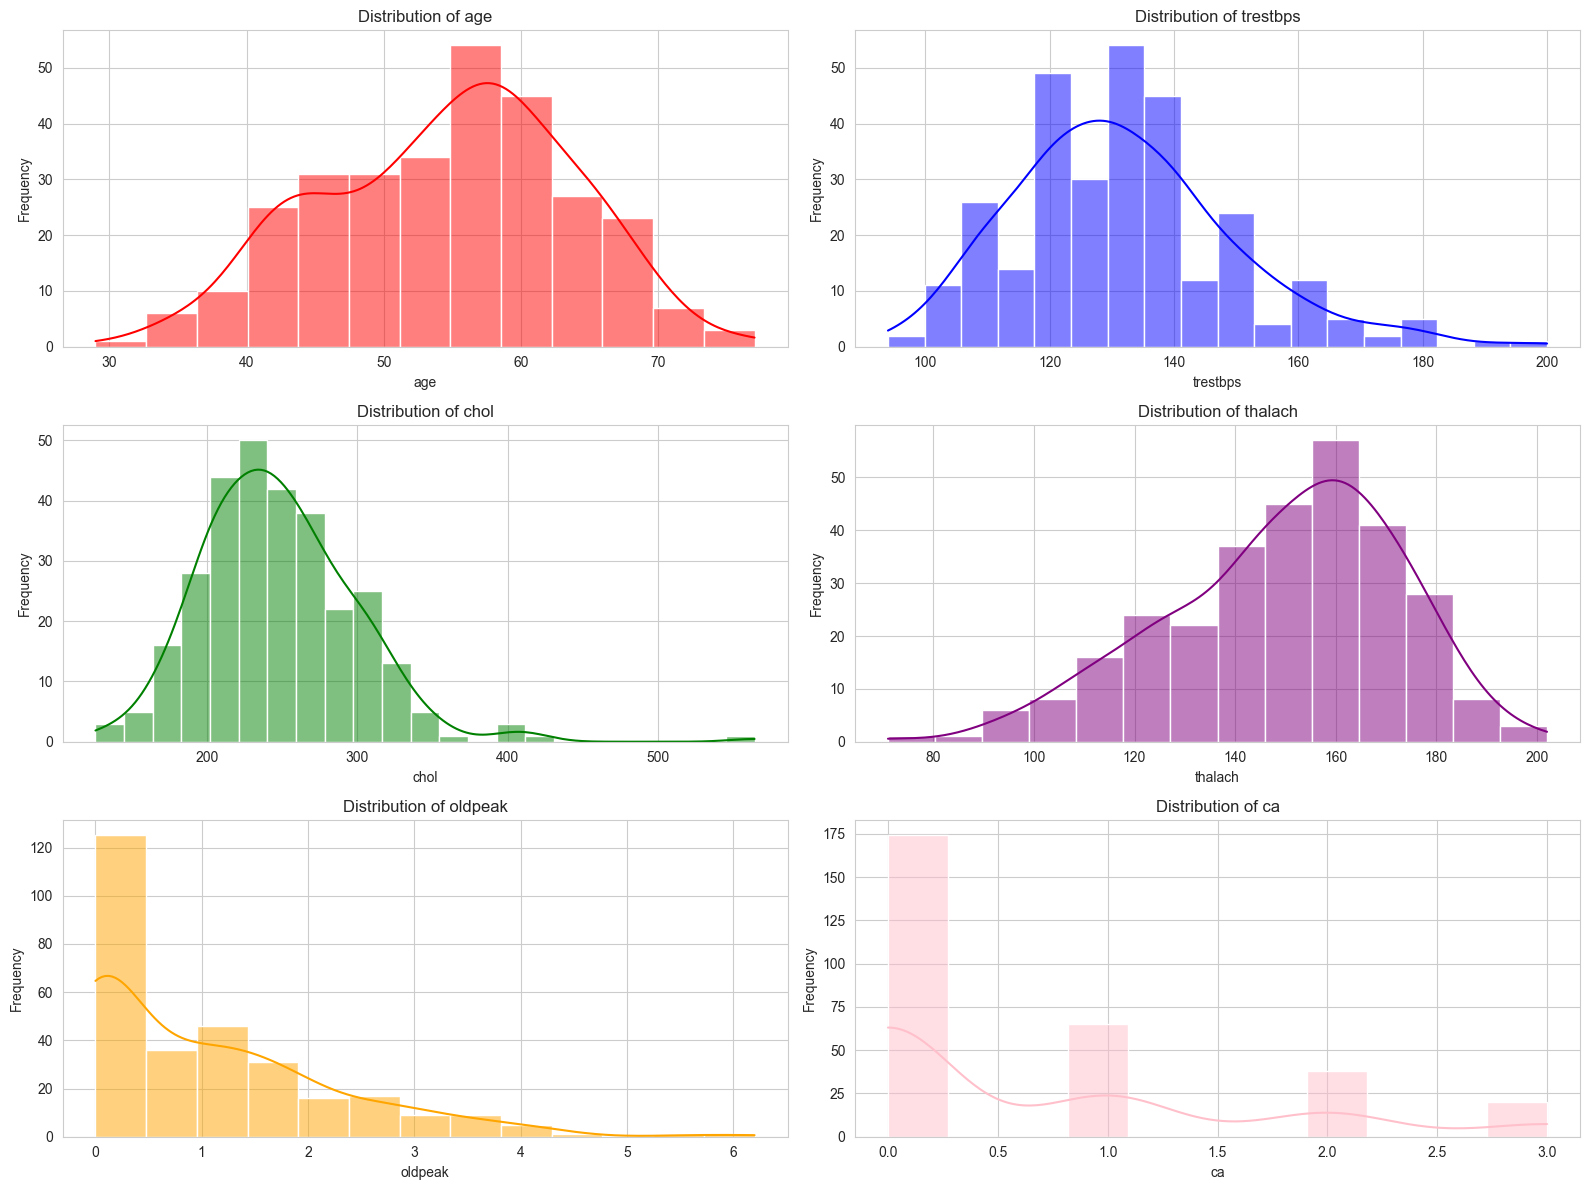

In [11]:
colors = ['red', 'blue', 'green', 'purple', 'orange', 'pink']  # Define a list of colors for the plots

fig, axes = plt.subplots(nrows=(len(numeric_features) + 1) // 2, ncols=2, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(numeric_features):
	sns.histplot(heart_disease[column], kde=True, bins="auto", color=colors[i % len(colors)], ax=axes[i])
	axes[i].set_title(f'Distribution of {column}')
	axes[i].set_xlabel(column)
	axes[i].set_ylabel('Frequency')

# Remove any empty subplots
for j in range(i + 1, len(axes)):
	fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

### Comments
Generally it appears as all these distributions contain one primary distribution, and a secondary smaller peak. `oldpeak` and `ca` are heavily skewed to the 0 result, because there are no negative results that make sense
### Scaling required
- `age`, `trestbps`, `thalach` are approximately normally distributed so StandardScaler will work fine
- `chol` appears to be right skewed, and has some outliers, we'll need to use RobustScaler
- `oldpeak` is heavily right skewed, so we'll need to use a MinMax or QuantileTransformer
- `ca` is also heavily right skewed, so we'll need to use a MinMax or QuantileTransformer

## Pipeline construction
The pipeline module of sci-kit learn allows us to construct a data pipeline. The data pipeline can perform all the transforms we'd need to do to our data, but encapsulate them in an object so it's easier to access their properties. In addition, once we have a pipeline, it's possible to perform hyperparameter searches on multiple steps in the pipeline, rather than just one. For example, we could perform a hyperparameter search that modifies the parameters of the scalers or encoders before getting to the logistic regression component

Based on what we learnt from the numeric distributions, we'll make a `scaling_encoding` ColumnTransformer that will apply the appropriate scalers or encoders to the columns in our dataset.

The general syntax  for the `ColumnTransformer` is `(str, transformer, columns_to_apply)`
Where the `str` is just a way to name and access that step, the `transformer` is any of the preprocessing transformers. We could give them all unique and easier to remember names, but the input column name is fine for now.

The advantage of a pipeline is that we could fairly easily swap out the `MinMaxScaler()` for a `QuantileTransformer()`, or we could try to use `KBinsDiscretizer()` on the `age` column given the small number of samples. It also prevents issues with Jupyter notebooks and order of operation of cells when modifying code. It's also useful in Data Engineering to construct a pipeline that the raw data goes into, and a working model comes out the other end.


In [12]:
scaling_encoding = ColumnTransformer(transformers=[
	('num', StandardScaler(), ['age', 'trestbps', 'thalach']),
	('chol', RobustScaler(), ['chol']),
	('oldpeak', MinMaxScaler(), ['oldpeak']),
	('ca_num', MinMaxScaler(), ['ca']),  # For numeric features of 'ca'
	('cp', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['cp']),
	('restecg', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['restecg']),
	('slope', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['slope']),
	# ('ca_cat', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['ca']),  # For categorical features of 'ca'
	('thal', OneHotEncoder(handle_unknown='infrequent_if_exist'), ['thal']),
	('exang', "passthrough", ['exang']),
	('fbs', "passthrough", ['fbs']),
	('sex', "passthrough", ['sex']),
])

The pipeline is a fairly simple preprocessor that we defined above, followed by a classifier, in this case LogisticRegression

In [13]:
pipeline = Pipeline(steps=[
	('preprocessor', scaling_encoding),
	('classifier', LogisticRegression(max_iter=1000, random_state=42, solver='lbfgs'))
])

# Dataset split
At a glance, the distribution of heart disease in the different sets seems to be consistent

In [14]:
# Fit the pipeline on the training data
pipeline.fit(X_train, y_train)

# Evaluate the pipeline on validation data
y_val_pred = pipeline.predict(X_val)

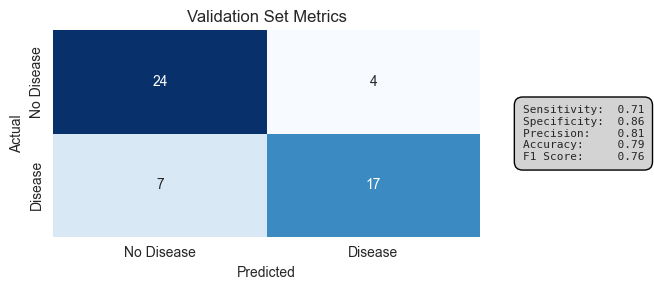

In [15]:
from sklearn.metrics import confusion_matrix, f1_score


def model_metrics(y_val, y_val_pred, title="Validation Set Metrics"):
	# Get confusion matrix
	cm = confusion_matrix(y_val, y_val_pred)
	# Extract components of confusion matrix
	tn, fp, fn, tp = cm.ravel()
	# Calculate metrics
	sensitivity = tp / (tp + fn)  # True Positive Rate (Recall)
	specificity = tn / (tn + fp)  # True Negative Rate
	precision = tp / (tp + fp)  # Positive Predictive Value
	accuracy = (tp + tn) / (tp + tn + fp + fn)
	f1 = f1_score(y_val, y_val_pred)  # F1 Score

	# Plot confusion matrix heatmap
	plt.figure(figsize=(5, 3))  # Increased figure width for better layout
	sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False, xticklabels=["No Disease", "Disease"],
				yticklabels=["No Disease", "Disease"])
	plt.title(title)
	plt.xlabel("Predicted")
	plt.ylabel("Actual")

	# Add metrics text to the right of the plot with adjusted position
	metrics_text = (
		f"Sensitivity:  {sensitivity:.2f}\n"
		f"Specificity:  {specificity:.2f}\n"
		f"Precision:    {precision:.2f}\n"
		f"Accuracy:     {accuracy:.2f}\n"
		f"F1 Score:     {f1:.2f}"
	)
	plt.gcf().text(
		1.1, 0.5, metrics_text, fontsize=8, family="monospace",  # Set font family to monospace
		bbox=dict(facecolor='lightgray', edgecolor='black', boxstyle='round,pad=0.75'),
		transform=plt.gca().transAxes, va='center'
	)
	plt.tight_layout(h_pad=5, w_pad=5)
	plt.show()


model_metrics(y_val, y_val_pred)

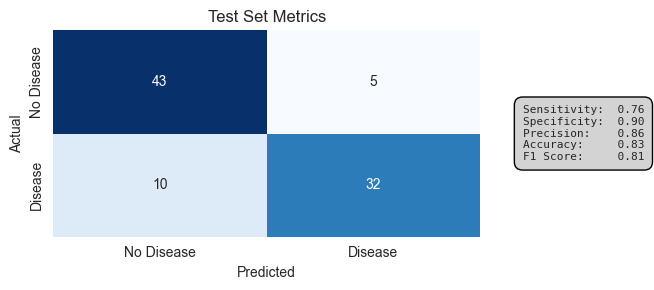

In [16]:
# Evaluate the pipeline on the test data
y_test_pred = pipeline.predict(X_test)

model_metrics(y_test, y_test_pred, "Test Set Metrics")

## Initial fit results
The validation set gives an F1 score of 0.76, which isn't great, but for a very quick logistic regression, it's ok. When we apply the same prediction to the test set, we see F1 score of 0.81. Indicating that any of the metrics we're using are going to have some variability of +/- 0.05 based on how the data split occurred. Note, it's probably not good practice to look at the test set until the model is done, but it's important to get a feel for how the scores we're optimising for can vary. We won't look at the test data set again until the end.

We're using F1 score because we don't have the domain knowledge to expertise to know whether minimising false negatives or false positives is the ultimate goal. Once constructed, it would be trivial to modify the code to select for one over the other. F1 aims for positive predictive power, emphasising precision and sensitivity



In [17]:
# Retrieve column names and coefficients from the pipeline
feature_names = scaling_encoding.get_feature_names_out()
coefficients = pipeline.named_steps['classifier'].coef_[0]
log_odds = [np.exp(coef) for coef in coefficients]

# Combine feature names and coefficients into a DataFrame for better readability
coef_df = pd.DataFrame({'Feature': feature_names, 'Log-Odds': coefficients, 'Odds': log_odds})

# Display the dataframe in descending order by 'Log-Odds'
coef_df = coef_df.sort_values(by='Log-Odds', ascending=False)
coef_df

,Feature,Log-Odds,Odds
5,ca_num__ca,2.008472,7.451923
9,cp__cp_4,1.348733,3.852543
21,sex__sex,0.894836,2.446934
4,oldpeak__oldpeak,0.788733,2.200607
18,thal__thal_7.0,0.652639,1.920603
15,slope__slope_3,0.569379,1.767169
19,exang__exang,0.539339,1.714874
12,restecg__restecg_2,0.298981,1.348484
1,num__trestbps,0.237414,1.267966
3,chol__chol,0.220511,1.246714


In [18]:
heart_disease['cp'].value_counts()

cp
4    142
3     83
2     49
1     23
Name: count, dtype: int64

In [19]:
heart_disease['thal'].value_counts()


thal
3.0    164
7.0    115
6.0     18
Name: count, dtype: int64

### Coefficients
Some predictors have a large predictive power
- `cp__cp_4` asymptomatic chest pain indicates that at the time of examination, the heart disease had not progressed to the point of causing pain. A little under half the dataset presented no chest pain
- `thal__thal_7.0` around a bit over a third of dataset had a reversible defect from Thalassemia
- `sex__sex` as might be expected, the gender of the patient has strong predictive power, something about males contributes to increased prevalance of heart disease
- `chol` cholesterol also strong at predicting heart disease, sits well with common knowledge people have about the circulatory system and the heart
- `ca_num__ca` the number of blood vessels, incorrect or restricted blood flow will lead to heart disease, so the number of vessels being lower than expected would be a strong predictor.

## Improving the model
We can make our model a bit simpler by removing the features we don't need. We'll use Recursive Feature Elimination (RFE) with Cross Validation (CV) to work out the optimum number of features. We'll make a new pipeline for it. We're going to reuse the preprocessor made before, but add a feature_selector step, that performs RFECV. We can then wrap that in a GridSearchCV to optimise the hyperparameters of the linear fit the RFECV

## RFECV pipeline construction
First we'll make the RFECV pipeline and check that it works.

Selected Feature Names: ['oldpeak__oldpeak', 'ca_num__ca', 'cp__cp_4', 'restecg__restecg_0', 'slope__slope_1', 'thal__thal_3.0', 'thal__thal_7.0', 'exang__exang']


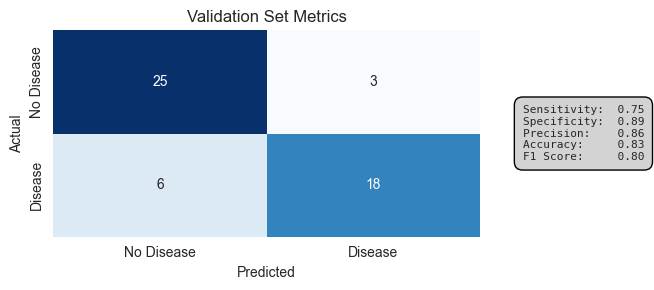

In [20]:
from sklearn.feature_selection import RFECV

# Implement RFECV with Logistic Regression
rfecv = RFECV(
	estimator=LogisticRegression(max_iter=2000, random_state=42, solver='lbfgs'),
	cv=5,
	scoring='f1',  # You can choose other metrics like 'f1', 'roc_auc', etc.
	step=1,
	min_features_to_select=5,
)

# Create the full pipeline
rfecv_pipeline = Pipeline(steps=[
	('preprocessor', scaling_encoding),  # Preprocessing step
	('feature_selector', rfecv)  # Perform RFECV with logistic regression
])

# Fit the rfecv_pipeline to the training data
rfecv_pipeline.fit(X_train, y_train)

# Evaluate the rfecv_pipeline on validation data
y_val_pred = rfecv_pipeline.predict(X_val)

# Get mask of selected features
selected_features = rfecv_pipeline.named_steps['feature_selector'].support_
feature_rankings = rfecv_pipeline.named_steps['feature_selector'].ranking_
optimal_features = rfecv_pipeline.named_steps['feature_selector'].n_features_

feature_names = scaling_encoding.get_feature_names_out()
selected_feature_names = [name for i, name in enumerate(feature_names) if selected_features[i]]
print("Selected Feature Names:", selected_feature_names)

model_metrics(y_val, y_val_pred)


## RFECV Pipeline Results
The F1 score for the validation set is no better than what we started with, the features selected match reasonably well with the log odds for our first fit, but let's not worry about it too much. Purpose of this was to validate the pipeline works

## Hyperparameter optimisation
We'll use a GridSearch on the pipeline and create a parameter grid, we'll add in some parameters to improve the logistic regression, as well as some to improve the feature selection [^1]



[^1] It would be reasonable to approach this by just testing a gridsearch on the logistic regression hyperparameters, and then just testing RFECV to see which one had the biggest improvement on the F1 score. Since this project has a dual purpose of building a better classifier for heart disease as well as teaching the author more about pipelines and sklearn syntax, the nested CV approach is being taken




In [21]:
from sklearn.model_selection import GridSearchCV

import warnings

In [22]:
param_grid = {
	# Logistic Regression hyperparameters
	'feature_selector__estimator__C': [0.01, 0.1, 1.0, 10.0, 100, 1000, 10000],  # Regularization strength
	'feature_selector__estimator__solver': ['liblinear', 'lbfgs'],  # Solver for optimization
	'feature_selector__estimator__penalty': ['l2'],
	'feature_selector__estimator__fit_intercept': [True, False],
	'feature_selector__estimator__max_iter': [5000],  # Maximum number of iterations for optimization

	# RFECV specific parameters
	'feature_selector__cv': [5],  # Number of CV folds
	'feature_selector__step': [1, 2],  # Number of features to eliminate in each step
	'feature_selector__min_features_to_select': [1, 5, 9, 13, 17, 21],  # Minimum number of features to retain
}

grid_search = GridSearchCV(
	estimator=rfecv_pipeline,
	param_grid=param_grid,
	scoring='f1',
	cv=5,
	verbose=1,
	n_jobs=2,
	error_score='raise'
)

# We're getting warnings because I think the OneHotEncoder and nested cross validation is generating some datasets that don't have all categorical feature values, and that feeds in NaN to a numpy function. Since it's relatively few, we'll still get a good model out if we let the GridSearchCV handle it
with warnings.catch_warnings(record=True) as w:
	warnings.simplefilter("always")
	grid_search.fit(X_train, y_train)
	for warn in w:
		print(f"Warning: {warn.message}")

Fitting 5 folds for each of 336 candidates, totalling 1680 fits


## Final results
The syntax for accessing the different components in a pipeline can be a little tricky to parse, but it's just nested properties. We'll select the best model for the pipeline, which is still accessed by `grid_search.best_estimator_` and fit it to the test data

In [23]:

# Get the best parameters
best_params = grid_search.best_params_
print("Best Parameters:", best_params)

best_model = grid_search.best_estimator_
best_model.fit(X_test, y_test)

Best Parameters: {'feature_selector__cv': 5, 'feature_selector__estimator__C': 10.0, 'feature_selector__estimator__fit_intercept': False, 'feature_selector__estimator__max_iter': 5000, 'feature_selector__estimator__penalty': 'l2', 'feature_selector__estimator__solver': 'liblinear', 'feature_selector__min_features_to_select': 9, 'feature_selector__step': 2}


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num', StandardScaler(),
                                                  ['age', 'trestbps',
                                                   'thalach']),
                                                 ('chol', RobustScaler(),
                                                  ['chol']),
                                                 ('oldpeak', MinMaxScaler(),
                                                  ['oldpeak']),
                                                 ('ca_num', MinMaxScaler(),
                                                  ['ca']),
                                                 ('cp',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['cp']),
                                                 ('restecg',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'...
                                                 ('thal',
                                                  OneHotEncoder(handle_unknown='infrequent_if_exist'),
                                                  ['thal']),
                                                 ('exang', 'passthrough',
                                                  ['exang']),
                                                 ('fbs', 'passthrough',
                                                  ['fbs']),
                                                 ('sex', 'passthrough',
                                                  ['sex'])])),
                ('feature_selector',
                 RFECV(cv=5,
                       estimator=LogisticRegression(C=10.0, fit_intercept=False,
                                                    max_iter=5000,
                                                    random_state=42,
                                                    solver='liblinear'),
                       min_features_to_select=9, scoring='f1', step=2))])

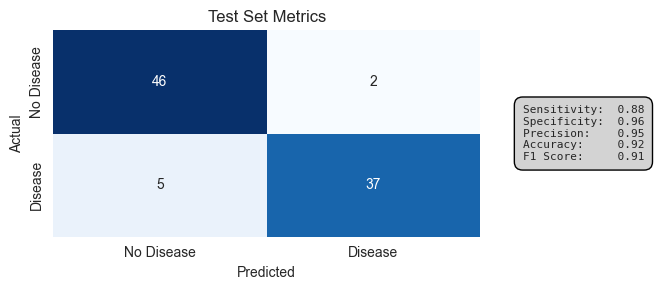

In [24]:
y_test_pred = best_model.predict(X_test)
metrics = model_metrics(y_test, y_test_pred, "Test Set Metrics")

### Test data results
The combination of RFECV and Logistic regression has resulted in a substantially improved model, beyond our uncertainty of +/- 0.05 for the F1 score. Only incorrectly classifying 7 patients from the test set. Interestingly, the `liblinear` solver was chosen, it's possible that made a substantial difference to the model alone, since we were initially testing only with `lbfgs`

In [25]:
# Get the feature names from the ColumnTransformer
feature_names = scaling_encoding.get_feature_names_out()

# Get the support mask from RFECV to know which of the features fed in were active
support_mask = grid_search.best_estimator_.named_steps['feature_selector'].support_

# Combine selected feature names from the preprocessor transformer and coefficients into a DataFrame for better readability
coefficients = best_model.named_steps['feature_selector'].estimator_.coef_[0]

# Select supported feature names
selected_feature_names = [name for i, name in enumerate(feature_names) if support_mask[i]]

# Create a DataFrame of feature coefficients
feature_coefficients = pd.DataFrame({
	'Feature': selected_feature_names,
	'Coefficient': coefficients
}).sort_values(by='Coefficient', ascending=False)

# Display the result
print(feature_coefficients)


               Feature  Coefficient
2           ca_num__ca     4.428990
1     oldpeak__oldpeak     2.480035
13            sex__sex     1.488919
4             cp__cp_4     1.084605
12        exang__exang     0.839831
10      thal__thal_6.0     0.657601
0         num__thalach    -0.474049
11      thal__thal_7.0    -0.655893
3             cp__cp_1    -0.865638
6   restecg__restecg_2    -0.970917
5   restecg__restecg_0    -1.097088
7       slope__slope_1    -1.204445
8       slope__slope_3    -1.774847
9       thal__thal_3.0    -1.926774


In [26]:
heart_disease['restecg'].value_counts()

restecg
0    147
2    146
1      4
Name: count, dtype: int64

In [27]:
heart_disease['slope'].value_counts()

slope
1    139
2    137
3     21
Name: count, dtype: int64

In [28]:
heart_disease['cp'].value_counts()

cp
4    142
3     83
2     49
1     23
Name: count, dtype: int64

### Coefficients of selected features for final logistic regression model
The selected features and their coefficients are not too dissimilar from what was ordered in the earlier model

#### Positive predictors
- `ca` the number of blood vessels has a strong predictive power
- `oldpeak` the depression after exercise relative to rest, a strong indicator something is wrong if the heart isn't returning to normal rhythm after exercise
- `sex` the gender of the patient still is a strong predictor
- `cp` chest pain type that is asymptomatic
- `exang` exercise angina, not surprising it's a positive predictor for heart disease
- `thal` only fixed defects for Thalassemia seem to predict, however if we recall there was only 18 cases of this, so not likely a useful predictor going out to a large dataset
#### Negative predictors
- `thal` reversible or no defects for Thalassemia strongly predict absence of heart disease, the
- `thalach` maximum heart rate achieved, predicting the absence of heart disease is makes sense, there is some research that indicates beta blockers have an impact on the test. The original data set does contain information about the patients if they are using beta blockers
- `slope` so long as the ST slope is not flat, the model predicts an absence of heart disease.
- `restecg` left ventricular hypertrophy is slightly more predictive of heart disease than a normal ECG


## Conclusion and next steps
We created a model using a GridSearch with cross validation, to recursively eliminate features with cross validation, to find the best logistic regression model.

We achieved an F1 score of 0.91, with only 7 of the 90 patients from the test set being predicted incorrectly.

### Model caveats
There are some features that could be dropped or considered unreliable given how little data for some categorical values was seen. There is also likely some cross correlation between these predictors and potential nonlinear effects that the training data doesn't reveal.

### Next steps
With the pipeline constructed, optimising for scaling and encoding of the model features before training could yield better results. Given the limited number of samples, putting some of the numerical features into discrete bins could be worth investigating, as well as trying Quantile Transformers.

Loading in the full dataset, with all 74 columns would allow us to potentially account for the beta blocker effects, but 300 samples and 74 features into 4, rather than just 2 classifications is not likely to build a robust model.

Based upon domain expertise, whether minimising false positives or false negatives is the goal, we could also change the scoring to make a model that's better at not missing heart disease or not wasting medical resources.
